b'\xeb+/B\xb2g\x04'
2019-12-22 03:35:37.116306
[2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729]
0.9999999999998741
0.9297385679074073
0.9999999999998741


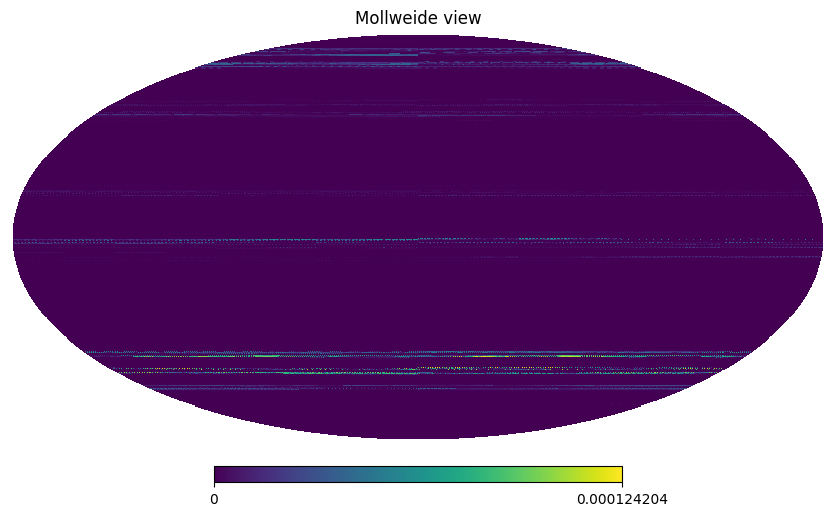

In [5]:
import os
import requests
import healpy as hp
from datetime import datetime
import numpy as np
from hashlib import blake2b

class AmpelHealpix():
    '''
    - Obtain and load (GW) Healpix map.
    - Get pixels above some probability threshold.
    - Get probability for some (ra,dec).
    '''
    
    # Disk storage
    save_dir: str = '.'


    def __init__(self, map_name: str, map_url: str, save_dir: None | str= None):
        self.map_name = map_name
        self.map_url = map_url
        if save_dir:
            self.save_dir = save_dir
        
        self._get_map()    
        # Attribues
        self.credible_levels: None | list = None
        self.trigger_time: None | datetime = None
        self.nside: None | int = None
   
   

    def _get_map(self, clobber=False) -> int:
        
        path = os.path.join(self.save_dir, self.map_name)
        
        if os.path.exists( path ) and not clobber:
            return 1
        
        # Retrieve mapfile.
        map_data = requests.get(self.map_url)

        with open(path, 'wb') as fh:
            fh.write(map_data.content)

        return 0
        

    def process_map(self):         
        '''
        Load map and determine prob values.
        '''
        
        # Process map
        hpx, headers = hp.read_map(os.path.join(self.save_dir, self.map_name), h=True, nest=True)
        trigger_time = [datetime.fromisoformat(header[1]) for header in headers if header[0] == 'DATE-OBS'][0]
        nside = int(hp.npix2nside(len(hpx)))

        hp.mollview(hpx)
        
        # Find credible levels
        idx = np.flipud(np.argsort(hpx))
        sorted_credible_levels = np.cumsum(hpx[idx].astype(float)) # why cumsum of 1D array? meaning?
        credible_levels = np.empty_like(sorted_credible_levels)
        credible_levels[idx] = sorted_credible_levels
        
        self.credible_levels = credible_levels
        self.trigger_time = trigger_time
        self.nside = nside

        return blake2b(sorted_credible_levels, digest_size=7).digest()


    def get_pixelmask(self, pvalue_limit):
        '''
        Return pixels with total probability up to some limit.
        '''
        
        if not self.nside:
            raise ValueError("First get and process map before using.")
                
        # Create mask for pixel selection
        mask = np.zeros(len(self.credible_levels), int)
        mask[self.credible_levels <= pvalue_limit] = 1
        return mask.nonzero()[0].tolist()
        
        
    def get_cumprob(self, ra: float, dec: float):
        '''
        Obtain probability for a specific coordinate based on loaded map.
        ra, dec in degrees.
        '''

        if not self.nside:
            raise ValueError("First get and process map before using.")
        
        
        theta = 0.5 * np.pi - np.deg2rad(dec)
        phi = np.deg2rad(ra)
        alertpix = hp.pixelfunc.ang2pix(hp.npix2nside(len(self.credible_levels)), theta, phi, nest=True)
        return self.credible_levels[alertpix]



        
        
def main():        
    ah = AmpelHealpix(map_name="S191222n.fits.gz", map_url="https://gracedb.ligo.org/api/superevents/S191222n/files/LALInference.fits.gz")
    hashit = ah.process_map()
    print(hashit)
    pixels = ah.get_pixelmask(0.9)
    print(ah.trigger_time)
    print(pixels[0:10])

    print( ah.get_cumprob(13,48) )
    print( ah.get_cumprob(200,-14.88) )
    print( ah.get_cumprob(68.58494, 33.89) )
        
#if __name__ == "__main__":
#    main()

main()

In [4]:
ah = AmpelHealpix(map_name="S191222n.fits.gz", map_url="https://gracedb.ligo.org/api/superevents/S191222n/files/LALInference.fits.gz")
hashit = ah.process_map()
print(hashit)
pixels = ah.get_pixelmask(0.9)
print(ah.trigger_time)
print(pixels[0:10])

print( ah.get_cumprob(13,48) )
print( ah.get_cumprob(200,-14.88) )
print( ah.get_cumprob(68.58494, 33.89) )

b'\xeb+/B\xb2g\x04'
2019-12-22 03:35:37.116306
[2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729]
0.9999999999998741
0.9297385679074073
0.9999999999998741
